In this case study, you'll apply what you've learned on confidence intervals and hypothesis testing **to help a company decide whether to launch two new features on their website** To do this, you'll analyze results from A/B testing, a valuable and widely practiced method in industry.

A/B tests are used to test changes on a web page by running an experiment where a **control group sees the old version**, while the **experiment group sees the new version**. A metric is then chosen to measure the level of engagement from users in each group. These results are then used to **judge whether one version is more effective than the other.** A/B testing is very much like hypothesis testing with the following hypotheses:

**Null Hypothesis:** The new version is no better, or even worse, than the old version <br>
**Alternative Hypothesis:** The new version is better than the old version
If we fail to reject the null hypothesis, the results would suggest keeping the old version. If we reject the null hypothesis, the results would suggest launching the change. **These tests can be used for a wide variety of changes, from large feature additions to small adjustments in color, to see what change maximizes your metric the most.**

**A/B testing also has its drawbacks.** It can help you compare two options, but it can't tell you about an option you haven’t considered. **It can also produce bias results when tested on existing users, due to factors like change aversion and novelty effect.**

**Change Aversion:** Existing users may give an unfair advantage to the old version, simply because they are unhappy with change, even if it’s ultimately for the better. <br>
**Novelty Effect:** Existing users may give an unfair advantage to the new version, because they’re excited or drawn to the change, even if it isn’t any better in the long run.

In this case study, you’ll analyze A/B test results for Audacity. **Here's the customer funnel for typical new users on their site:**

**View home page > Explore courses > View course overview page > Enroll in course > Complete course**

Audacity loses users as they go down the stages of this funnel, with only a few making it to the end. To increase student engagement, Audacity is performing A/B tests to try out changes that will hopefully increase conversion rates from one stage to the next.

**We’ll analyze test results for two changes they have in mind, and then make a recommendation on whether they should launch each change.**

Have questions? Head to Udacity Knowledge for discussion with the Udacity 

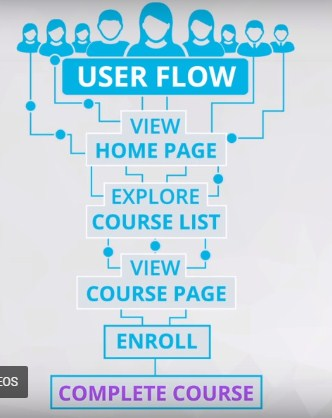

# TYPE OF CHANGES

# 1st CHANGE

**The first change Audacity wants to try is on their homepage.** They hope that this new, more engaging design will increase the number of users that explore their courses, that is, move on to the second stage of the funnel.

The **metric** we will use is the **click through rate for the Explore Courses button on the home page.** <<br>

**Click through rate (CTR)** is often defined as the the **number of clicks divided by the number of views.** Since Audacity uses cookies, we can identify unique users and make sure we don't count the same one multiple times. For this experiment, we'll define our click through rate as:

**CTR: # clicks by unique users / # views by unique users**

$$H_0: CTR_(new) \leq CTR_(old)$$
$$H_1: CTR_new > CTR_(old)$$

$$H_0: CTR_(new) - CTR_(old) \leq 0$$
$$H_1: CTR_(new) - CTR_(old) > 0$$

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df= pd.read_csv(r"Audacity_homepage.csv")
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [24]:
# total number of actions
total_actions = df.shape[0]
print ("TOTAL NUMBER OF ACTIONS IS %s" %total_actions)

TOTAL NUMBER OF ACTIONS IS 8188


In [25]:
# number of unique users
unique_users = df.id.nunique()
print ("NUMBER OF UNIQUE USERS IS %s" %unique_users)

NUMBER OF UNIQUE USERS IS 6328


In [26]:
df.groupby(["group"], as_index = False)["id"].nunique()

0    3332
1    2996
Name: id, dtype: int64

In [27]:
# size of control group and experiment group (unique users)
cont_group = df[df["group"] == 'control']["id"].nunique()
exp_group = df[df["group"] == 'experiment']["id"].nunique()
print ("SIZE OF CONTROL GROUP (UNIQUE) IS %s" %cont_group)
print ("SIZE OF EXPERIMENT GROUP (UNIQUE) IS %s" %exp_group)

SIZE OF CONTROL GROUP (UNIQUE) IS 3332
SIZE OF EXPERIMENT GROUP (UNIQUE) IS 2996


### 2. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [28]:
# duration of this experiment
df.timestamp.max(), df.timestamp.min()
print ("DURATION OF THE EXPERIMENT IS 4 months")

DURATION OF THE EXPERIMENT IS 4 months


### 3. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [29]:
# action types in this experiment
df.action.value_counts(), print ("THERE ARE 2 TYPES OF ACTIONS: view and click")

THERE ARE 2 TYPES OF ACTIONS: view and click


(view     6328
 click    1860
 Name: action, dtype: int64, None)

### 4. Why would we use click through rate instead of number of clicks to compare the performances of control and experiment pages?

Using the number of clicks only is not an appropriate technique as in one group might be the higher number of clicks just because of the higher number of views. So, we need to take proportions.

Getting the proportion of the users who click is more effective than getting the number of users who click when comparing groups of different sizes.

### 5. Define the click through rate (CTR) for this experiment.

CTR: # clicks by unique users / # views by unique users

### 6. What are the null and alternative hypotheses?
Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.

$$H_0: CTR_{new} - CTR_{old} \leq 0  $$
$$H_1: CTR_{new} - CTR_{old} > 0                  $$

**STEPS** we take to analyze the results of this A/B test.

* We compute the observed difference between the metric, click through rate, for the control and experiment group.
* We simulate the sampling distribution for the difference in proportions (or difference in click through rates).
* We use this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.
* We compute the p-value by finding the proportion of values in the null distribution that were greater than our observed difference.
* We used this p-value to determine the statistical significance of our observed difference.

### We compute the observed difference between the metric, click through rate, for the control and experiment group.

In [30]:
# CONTROL GROUP
control_df = df.query("group == 'control'")
control_df.head(3)

,timestamp,id,group,action
3,2016-09-24 19:59:02.646620,671993,control,view
9,2016-09-24 21:00:12.278374,560027,control,view
23,2016-09-25 00:25:14.141290,281985,control,view


In [31]:
control_ctr = control_df.query("action == 'click'").id.nunique() / control_df.query("action == 'view'").id.nunique()
print ("THE CTR for CONTROL GROUP IS %s" %control_ctr)

THE CTR for CONTROL GROUP IS 0.2797118847539016


In [32]:
# EXPERIMENT GROUP
experiment_df = df.query("group == 'experiment'")
experiment_df.head(3)

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view


In [33]:
experiment_ctr = experiment_df.query("action == 'click'").id.nunique() / experiment_df.query("action == 'view'").id.nunique()
print ("THE CTR for EXPERIMENT GROUP IS %s" %experiment_ctr)

THE CTR for EXPERIMENT GROUP IS 0.3097463284379172


In [34]:
# observed difference between the metric
obs_diff = experiment_ctr - control_ctr
print ("THE OBSERVED DIFFERENCE BETWEEN THE METRIC in control and experiment groups IS %s" %obs_diff)

THE OBSERVED DIFFERENCE BETWEEN THE METRIC in control and experiment groups IS 0.030034443684015644


### We simulate the sampling distribution for the difference in proportions (or difference in click through rates).

In [54]:
# bootstrap our data
diffs = []

for i in range(1000):
    b_samp = df.sample(200, replace = True) 
    # every sample with the same number of values as given data
    control_df = b_samp.query("group == 'control'")
    experiment_df = b_samp.query("group == 'experiment'")
    control_ctr = control_df.query("action == 'click'").id.nunique() / control_df.query("action == 'view'").id.nunique()
    experiment_ctr = experiment_df.query("action == 'click'").id.nunique() / experiment_df.query("action == 'view'").id.nunique()
    experiment_ctr - control_ctr
    print (b_samp.shape[0])
    diffs.append(experiment_ctr - control_ctr)

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


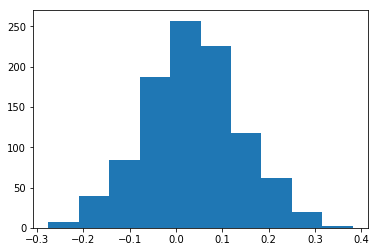

In [53]:
# plot sampling distribution
plt.hist(diffs);

### We use this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.

We create a normal distribution centered at 0 with the same STD as our sampling distribution we simulated before.

In [18]:
# simulate normal distribution
diffs = np.array(diffs)
null_mean = 0
null_vals = np.random.normal(loc = null_mean, scale = np.std(diffs), size = diffs.size)

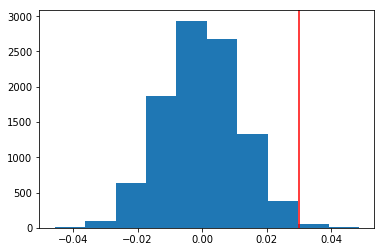

In [19]:
# plot simulated normal distribution and indicate our observed difference
plt.hist(null_vals);
plt.axvline(obs_diff, color = 'r');

**Our statistic (actual observed diff) is further out from the bulk of the distribution above, this suggests that the NULL WASN'T LIKELY TO HAVE GENERATED OUR STATISTIC.**

### We compute the p-value by finding the proportion of values in the null distribution that were greater than our observed difference.

In [20]:
# computing p-value
(null_vals > obs_diff).mean()

0.0061

**So, as p-value < 0.01 we reject the Ho** It seems unlikely that our statistic is from this Ho. <br>
**The difference in CTR for the control and experiment groups does appear to be significant.** <br>
**Audacity should launch the new page**

# 2nd CHANGE

The **second change** Audacity is A/B testing **is a more career focused description on a course overview page.** They hope that this change may encourage more users to enroll and complete this course. In this experiment, we’re going to analyze the following **metrics:**

**Enrollment Rate:** Click through rate for the Enroll button the course overview page <br>
**Average Reading Duration:** Average number of seconds spent on the course overview page <br>
**Average Classroom Time:** Average number of days spent in the classroom for students enrolled in the course <br>
**Completion Rate:** Course completion rate for students enrolled in the course

# METRIC 1 (Enrollment rate, proportions)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
np.random.seed(42)

df = pd.read_csv("course_page_actions.csv")
df.head(3)

In [ ]:
df.id.nunique()

In [ ]:
# Get dataframe with all records from control group
control_df = df.query('group == "control"')

# Compute click through rate for control group (enroll VS view)
control_ctr = control_df.query("action == 'enroll'").id.nunique() / control_df.query("action == 'view'").id.nunique()

# Display click through rate
print ("THE CTR for CONTROL GROUP IS %s" %control_ctr)

In [ ]:
control_df.query("action == 'view'").id.nunique(), control_df.query("action == 'view'").count()[0]

In [ ]:
# Get dataframe with all records from experiment group
experiment_df = df.query("group == 'experiment'")

# Compute click through rate for experiment group
experiment_ctr = experiment_df.query("action == 'enroll'").id.nunique() / experiment_df.query("action == 'view'").id.nunique()

# Display click through rate
print ("THE CTR for EXPERIMENT GROUP IS %s" %experiment_ctr)

In [ ]:
# Compute the observed difference in click through rates
obs_diff = experiment_ctr - control_ctr

# Display observed difference
print ("THE OBSERVED DIFFERENCE BETWEEN THE METRIC 1 in control and experiment groups IS %s" %obs_diff)

In [ ]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
for i in range(10000):
    b_samp = df.sample(df.shape[0], replace = True)
    control_df = b_samp.query("group == 'control'")
    experiment_df = b_samp.query("group == 'experiment'")
    control_ctr = control_df.query("action == 'enroll'").id.nunique() / control_df.query("action == 'view'").id.nunique()
    experiment_ctr = experiment_df.query("action == 'enroll'").id.nunique() / experiment_df.query("action == 'view'").id.nunique()
    experiment_ctr - control_ctr
    diffs.append(experiment_ctr - control_ctr)

In [ ]:
# Convert to numpy array
diffs = np.array(diffs)

# Plot sampling distribution
plt.hist(diffs);

In [ ]:
# Simulate distribution under the null hypothesis
null_mean = 0
null_vals = np.random.normal(loc = null_mean, scale = np.std(diffs), size = diffs.size)

# Plot the null distribution
plt.hist(null_vals);

In [ ]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff, color = 'r')

**Our statistic (actual observed diff) is further out from the bulk of the distribution above, this suggests that the NULL WASN'T LIKELY TO HAVE GENERATED OUR STATISTIC.**

In [ ]:
# Compute p-value
(null_vals > obs_diff).mean()

**So, as p-value < 0.05 we reject the Ho** It seems likely that our statistic is not from this Ho. <br>
**The difference in CTR for the control and experiment groups does appear to be significant.** <br>
**Audacity should launch the new course overview page**

# METRIC 2 (Average reading duration, difference in means)

In [ ]:
# We care only the view action.
views = df.query("action == 'view'")
# Let's only count each unique user once by finding their average reading duration if they visited the site more than once
reading_times = views.groupby(["id", "group"])["duration"].mean()
reading_times = reading_times.reset_index()
reading_times.head()

In [ ]:
df.id.nunique(), df.shape[0]

In [ ]:
control_mean = df.query("group == 'control'")["duration"].mean()
experiment_mean = df.query("group == 'experiment'")["duration"].mean()
control_mean, experiment_mean

In [ ]:
obs_diff = experiment_mean - control_mean
print ("THE OBSERVED DIFFERENCE BETWEEN THE METRIC 2 in control and experiment groups IS %s" %obs_diff)

In [ ]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
for i in range(10000):
    b_samp = df.sample(df.shape[0], replace = True)
    control_df = b_samp.query("group == 'control'")
    experiment_df = b_samp.query("group == 'experiment'")
    control_mean = control_df.query("group == 'control'")["duration"].mean()
    experiment_mean = experiment_df.query("group == 'experiment'")["duration"].mean()
    experiment_mean - control_mean
    diffs.append(experiment_mean - control_mean)

In [ ]:
# Convert to numpy array
diffs = np.array(diffs)

# Plot sampling distribution
plt.hist(diffs);

In [ ]:
# Simulate distribution under the null hypothesis
null_mean = 0
null_vals = np.random.normal(loc = null_mean, scale = np.std(diffs), size = diffs.size)

# Plot the null distribution
plt.hist(null_vals);

In [ ]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff, color = 'r')

**Our statistic (actual observed diff) is further out from the bulk of the distribution above, this suggests that the NULL WASN'T LIKELY TO HAVE GENERATED OUR STATISTIC.**

In [ ]:
# Compute p-value
(null_vals > obs_diff).mean()

**So, as p-value < 0.05 we reject the Ho** It seems likely that our statistic is not from this Ho. <br>
**The difference in average time on the page for the control and experiment groups does appear to be significant.** <br>
**Audacity should launch the new course overview page**

# METRIC 3 (Average Classroom Time, difference in means)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
np.random.seed(42)

df = pd.read_csv(r"D:\2018_TIME_TO_CHANGE\UDACITY\PART 3 (Practical Statistics)\classroom_actions.csv")
df.head(3)

In [ ]:
df.id.nunique(), df.shape[0]

In [ ]:
# The total_days represents the total amount of time
# each student has spent in classroom.
# get the average classroom time for control group
control_mean = df.query("group == 'control'").total_days.mean()

# get the average classroom time for experiment group
experiment_mean = df.query("group == 'experiment'").total_days.mean()

# display average classroom time for each group
control_mean, experiment_mean

In [ ]:
obs_diff = experiment_mean - control_mean
print ("THE OBSERVED DIFFERENCE BETWEEN THE METRIC 3 in control and experiment groups IS %s" %obs_diff)

In [ ]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
for i in range(10000):
    b_samp = df.sample(df.shape[0], replace = True)
    control_df = b_samp.query("group == 'control'")
    experiment_df = b_samp.query("group == 'experiment'")
    control_mean = control_df.query("group == 'control'")["total_days"].mean()
    experiment_mean = experiment_df.query("group == 'experiment'")["total_days"].mean()
    experiment_mean - control_mean
    diffs.append(experiment_mean - control_mean)

In [ ]:
# Convert to numpy array
diffs = np.array(diffs)

# Plot sampling distribution
plt.hist(diffs);

In [ ]:
# Simulate distribution under the null hypothesis
null_mean = 0
null_vals = np.random.normal(loc = null_mean, scale = np.std(diffs), size = diffs.size)

# Plot the null distribution
plt.hist(null_vals);

In [ ]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff, color = 'r');

**Our statistic (actual observed diff) is in the bulk of the distribution above, this suggests that the NULL WAS LIKELY TO HAVE GENERATED OUR STATISTIC.**

In [ ]:
# Compute p-value
(null_vals > obs_diff).mean()

**So, as p-value < 0.05 we reject the Ho** It seems likely that our statistic is not from this Ho. <br>
**The difference in average time on the page for the control and experiment groups does appear to be statistically significant.** <br>
This difference practically is not significant <br>
**Audacity should not launch the new course overview page**

# METRIC 4 (Completion rate)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
np.random.seed(42)

df = pd.read_csv(r"D:\2018_TIME_TO_CHANGE\UDACITY\PART 3 (Practical Statistics)\classroom_actions.csv")
df.head(3)

In [ ]:
df.id.nunique(), df.shape[0]

In [ ]:
# Create dataframe with all control records
control_df = df.query("group == 'control'")

# Compute completion rate
control_ctr = control_df.query("completed == True").id.nunique() / control_df.id.nunique()

# Display completion rate
print ("THE COMPLETION RATE for CONTROL GROUP IS %s" %control_ctr)

In [ ]:
# Create dataframe with all experiment records
experiment_df = df.query("group == 'experiment'")

# Compute completion rate
experiment_ctr = experiment_df.query("completed == True").id.nunique() / experiment_df.id.nunique()

# Display completion rate
print ("THE COMPLETION RATE for EXPERIMENT GROUP IS %s" %experiment_ctr)

In [ ]:
# Compute observed difference in completion ratesb
obs_diff = experiment_ctr - control_ctr

# Display observed difference in completion rates
print ("THE OBSERVED DIFFERENCE BETWEEN THE METRIC 4 in control and experiment groups IS %s" %obs_diff)

In [ ]:
# Create sampling distribution for difference in completion rates
# with boostrapping
diffs = []
size = df.shape[0]
for i in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df['completed'].mean()
    experiment_ctr = experiment_df['completed'].mean()
    diffs.append(experiment_ctr - control_ctr)

In [ ]:
# convert to numpy array
diffs = np.array(diffs)
# plot distribution
plt.hist(diffs);

In [ ]:
# Simulate distribution under the null hypothesis
null_mean = 0
null_vals = np.random.normal(loc = null_mean, scale = np.std(diffs), size = diffs.size)

# Plot the null distribution
plt.hist(null_vals);


In [ ]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff, color = 'r');

**Our statistic (actual observed diff) is out of the bulk of the distribution above, this suggests that the NULL WAS NOT LIKELY TO HAVE GENERATED OUR STATISTIC.**

In [ ]:
# Compute p-value
(null_vals > obs_diff).mean()

**So, as p-value > 0.05 we fail to reject the Ho** It seems likely that our statistic is from this Ho. <br>
**The difference in average time on the page for the control and experiment groups does not appear to be statistically significant.** <br>
**Audacity should not launch the new course overview page**

#  Bonferroni corrected alpha value

Before Bonferroni: <br>
Metric 1 - REJECT<br>
Metric 2 - REJECT<br>
Metric 3 - REJECT<br>
Metric 4 - FAIL TO REJECT

In [ ]:
alpha = 0.05/4
print ("NEW ALPHA IS %s" %alpha)

**What results are still statistically significant?** <br>
Let's see which of our metrics produced statistically significant differences based on this new alpha value.**Here are the p-values computed for the four metrics in this experiment.** (These are the values you should've gotten with a random seed of 42.)

Enrollment Rate: 0.0624    (mine is 0.0188)       **FAIL TO REJECT Ho**<br>  

Average Reading Duration: 0       **REJECT Ho**<br>

Average Classroom Time: 0.0384    **FAIL TO REJECT Ho**<br>

Completion Rate: 0.0846           **FAIL TO REJECT Ho**<br>

**Since the Bonferroni method is too conservative** when we expect correlation among metrics, we can better approach this problem with more sophisticated methods, **such as the closed testing procedure, Boole-Bonferroni bound, and the Holm-Bonferroni method.** These are less conservative and take this correlation into account.

**If you do choose to use a less conservative method, just make sure the assumptions of that method are truly met in your situation, and that you're not just trying to cheat on a p-value.** Choosing a poorly suited test just to get significant results will only lead to misguided decisions that harm your company's performance in the long run.

# Difficulties in A/B Testing

### Scenario #1

**EXPERIMENT:** Audacity tests a new layout in the classroom to see if it would help engage students. After running an A/B test for two weeks, they find that average classroom times and completion rates decrease with the new layout, and decide against launching the change.

**REALITY:** What they don't know, is that the classroom times and completion rates actually increase significantly for new students using the new layout. In the long run, the layout would help existing students too, but they are currently **experiencing change aversion.**

In order to **protect against change aversion**, we need to **run the experiment long enough for existing users** to acclimate to the changes. Fortunately, users who are new won't have preconceptions regarding the original version.

### Scenario #2
**EXPERIMENT:** Audacity tests a new feature on their landing page that guides users through their course selection process and makes recommendations. After running an A/B test for a month, they find that the click through rates on course pages increase (enrollment rates increase) with the new feature, and decide to launch the change.

**REALITY:** What they don't know, is that although the number of total enrollments increase with the new feature, the courses they are purchasing are almost exclusively shorter and cheaper courses, which brings down the revenue for Audacity. It turns out the feature is leading more students to choose more courses with smaller commitments.

Measuring the right metric is a key component to A/B testing. In this case, we would want to account for revenue more so than enrollment rates alone.

### Scenario #3
**EXPERIMENT:** Audacity tests a new description for a difficult course that gets very few enrollments. They hope this description is more exciting and motivates students to take it. After running an A/B test for five weeks, they find that the enrollment rate increases with the new description, and decide to launch the change.

**REALITY:** What they don't know, is that although the enrollment rate appears to increase with the new description, the results from this A/B test are unreliable and largely due to chance, because fewer than 40 out of thousands of visitors enrolled during this experiment. This makes even one new student for the course substantially impact the results and potentially even the conclusion.

In this case, we needed to have more time and traffic to the page to see if the change had a significant impact.

**As you saw in the scenarios above, there are many factors to consider when designing an A/B test and drawing conclusions based on its results. To conclude, here are some common ones to consider.**

* Novelty effect and change aversion when existing users first experience a change
* Sufficient traffic and conversions to have significant and repeatable results
* Best metric choice for making the ultimate decision (eg. measuring revenue vs. clicks)
* Long enough run time for the experiment to account for changes in behavior based on time of day/week or seasonal events.
* Practical significance of a conversion rate (the cost of launching a new feature vs. the gain from the increase in conversion)
* Consistency among test subjects in the control and experiment group (imbalance in the population represented in each group can lead to situations like Simpson's Paradox)